In [1]:
import metrics
import dspy
import os
import yaml
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import examples

with open(os.path.join("..", "keys.yaml"), "r") as file:
    config = yaml.safe_load(file)
    openai_api_key = config["openai_api_key"]
    
grader = dspy.OpenAI(
            model="gpt-4o",
            model_type="chat",
            max_tokens=2000,
            api_key=openai_api_key,
            temperature=0.3,
        )
    
os.environ["DSP_CACHEBOOL"] = "False"

max_score = metrics.MAX_SCORE

In [2]:
empty_input = dspy.Example()

# Test 1: Conciseness

In [3]:
short_output = dspy.Prediction(narrative='word ')
short_result = metrics.conciseness(empty_input, short_output, max_optimal_length=10)
assert short_result == max_score, short_result

long_output = dspy.Prediction(narrative='word ' * 21)
long_result = metrics.conciseness(empty_input, long_output, max_optimal_length=10)
assert long_result == 0, long_result

med_output = dspy.Prediction(narrative='word ' * 15)
med_result = metrics.conciseness(empty_input, med_output, max_optimal_length=10)
assert med_result == max_score / 2, med_result

# Test 2: Accuracy

In [4]:
test_input = dspy.Example(explanation='(Size, 5, 10), (Color, Red, -8)', 
                          explanation_format='(feature_name, feature_value, SHAP contribution)')

accurate_output = dspy.Prediction(narrative='The size being 5 increased the prediction by 10. The color being red decreased the prediction by 8.')
accurate_result = metrics.accuracy(test_input, accurate_output, grader=grader)
assert accurate_result == max_score, accurate_result

inaccurate_output = dspy.Prediction(narrative='The size being 4 increased the prediction by 11. The color being red decreased the prediction by 9.')
inaccurate_result = metrics.accuracy(test_input, inaccurate_output, grader=grader)
assert inaccurate_result == 0, inaccurate_result

incomplete_but_accurate_output = dspy.Prediction(narrative='The size being 5 increased the prediction by 10.')
incomplete_but_accurate_result = metrics.accuracy(test_input, incomplete_but_accurate_output, grader=grader)
assert incomplete_but_accurate_result == max_score, incomplete_but_accurate_result

In [5]:
grader.inspect_history(n=1)




Assess a narrative based on a rubric.

---

Follow the following format.

Question: ${question}

Narrative: ${narrative}

Rubric: ${rubric}

Assessment: A single number from the options in the rubric. Provide only a single number with no other text.

---

Question:
How accurate is the information in the narrative, based on the explanation given? A narrative can score 4 even if it is missing information as long as everything in the narrative is correct. Make sure the contribution direction is correct - positive contributions increase the output, negative contributions decrease the output.

Explanation format: (feature_name, feature_value, SHAP contribution).
Explanation: (Size, 5, 10), (Color, Red, -8)

Narrative: The size being 5 increased the prediction by 10.

Rubric: 0 - Contains one or more errors in value or contribution direction. 4 - Contains no errors, but may be missing information.

Assessment: 4


'\n\n\nAssess a narrative based on a rubric.\n\n---\n\nFollow the following format.\n\nQuestion: ${question}\n\nNarrative: ${narrative}\n\nRubric: ${rubric}\n\nAssessment: A single number from the options in the rubric. Provide only a single number with no other text.\n\n---\n\nQuestion:\nHow accurate is the information in the narrative, based on the explanation given? A narrative can score 4 even if it is missing information as long as everything in the narrative is correct. Make sure the contribution direction is correct - positive contributions increase the output, negative contributions decrease the output.\n\nExplanation format: (feature_name, feature_value, SHAP contribution).\nExplanation: (Size, 5, 10), (Color, Red, -8)\n\nNarrative: The size being 5 increased the prediction by 10.\n\nRubric: 0 - Contains one or more errors in value or contribution direction. 4 - Contains no errors, but may be missing information.\n\nAssessment:\x1b 4\x1b\n\n\n'

Explanation: (Quality of materials out of 10, 3, 560.46), (Size in sq ft, 1020, 909)
Output: The house's quality of 3/10 increased the model's prediction by around 500, while its size of around 1000 sq ft increased it by about 900
Expected: 4. Got: 0.0
Explanation: (Number of streams, 1.00, 0.10), (Number of objects, 1.00, 0.10)
Output: The file's number of streams increases the model's prediction by 10
Expected: 0. Got: 4.0
Explanation: (In a romantic relationship, yes, -2.00), (Family educational support, yes, 2.00), (Absences, high, -4.00)
Output: Being in a romantic relationship decreases the student's likelihood of passing.
Expected: 4. Got: 0.0


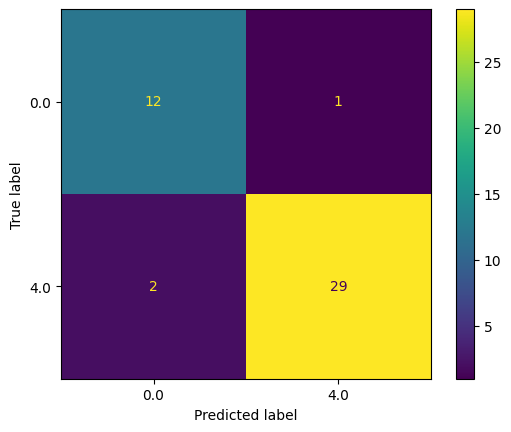

In [6]:
accuracy_dataset = json.load(open("accuracy_tests.json"))

preds = []
actuals = []
for example in accuracy_dataset:
    test_input = dspy.Example(explanation=example["explanation"], explanation_format=example["explanation_format"])
    test_output = dspy.Prediction(narrative=example["narrative"])
    result = metrics.accuracy(test_input, test_output, grader)
    preds.append(result)
    actuals.append(example["accuracy_score"])
    if result != example["accuracy_score"]:
        print(f'Explanation: {example["explanation"]}')
        print(f'Output: {example["narrative"]}')
        print(f'Expected: {example["accuracy_score"]}. Got: {result}')

cm = confusion_matrix(actuals, preds, labels=[0.0, 4.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0.0, 4.0])
disp.plot()

# Test 3: Completeness

In [7]:
test_input = dspy.Example(explanation='(Size, 5, 10), (Color, Red, -8), (Shape, Square, 3)', 
                          explanation_format='(feature_name, feature_value, SHAP contribution)')

complete_output = dspy.Prediction(narrative='The size being 5 increased the prediction by 10. The color being red decreased the prediction by 8. The shape being square increased the prediction by 3.')
complete_result = metrics.completeness(test_input, complete_output, grader)
assert complete_result == max_score, complete_result

incomplete_output = dspy.Prediction(narrative='The size being 5 increased the prediction by 10')
incomplete_result = metrics.completeness(test_input, incomplete_output, grader)
assert incomplete_result == 0, incomplete_result

Explanation: (Type of foundation, Wood, -18650.67), (Physical locations within Ames city limits, Mitchel, -13510.92), (Three season porch area in square feet, 320.00, 9959.33)
Output: The wood foundation and Mitchel location reduce the price, while the porch area of around 300 increases it.
Expected: 4. Got: 2.0
Explanation: (Type 1 finished square feet, 1369.00, 14641.53), (Evaluates the height of the basement, Ex, 13233.24), (Total square feet of basement area, 1686.00, 12138.28), (Second floor square feet, 0.00, -10142.29), (Rates the overall material and finish of the house, 8.00, 9655.79)
Output: This house's relatively large type 1 finished square footage increased the predicted price by about $14,000. The house's excellent basement height increased the price by about $13,000. The relatively larger basement area increased the price by about $12,000. The absence of a second floor reduced the price by about $10,000. The house's good condition (rated 8/10) increased the price by abo

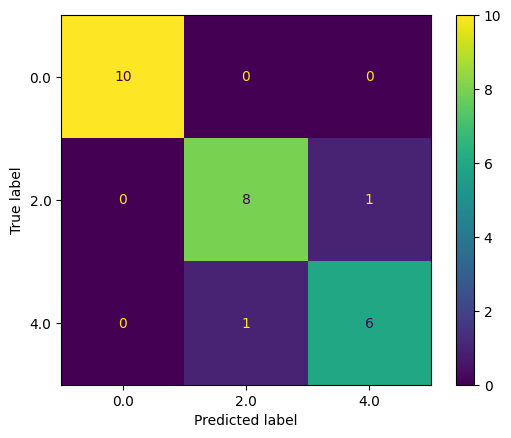

In [8]:
from collections import defaultdict

completeness_dataset = json.load(open("completeness_tests.json"))

preds = []
actuals = []
rationalization_when_failing = defaultdict(int)
for example in completeness_dataset:
    test_input = dspy.Example(explanation=example["explanation"], explanation_format=example["explanation_format"])
    test_output = dspy.Prediction(narrative=example["narrative"])
    result = metrics.completeness(test_input, test_output, grader)
    preds.append(result)
    actuals.append(example["completeness_score"])
    if result != example["completeness_score"]:
        print(f'Explanation: {example["explanation"]}')
        print(f'Output: {example["narrative"]}')
        print(f'Expected: {example["completeness_score"]}. Got: {result}')

cm = confusion_matrix(actuals, preds, labels=[0.0, 2.0, 4.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0.0, 2.0, 4.0])
disp.plot()

In [9]:
grader.inspect_history(n=1)




Assess a narrative based on a rubric.

---

Follow the following format.

Question: ${question}

Narrative: ${narrative}

Rubric: ${rubric}

Start by listing out all the features in the explanations, and then determine every feature is present in the narrative, along with its value and contribution direction. Feature-by-feature processing of the narrative.

Assessment: A single number from the options in the rubric. Provide only a single number with no other text.

---

Question:
How completely does the narrative below describe the explanation given in <<>>?
Explanation format: SHAP feature contribution in (feature_name, feature_value, contribution) format.
Explanation: <<(Number of past class failures, 0.00, 0.89), (Wants to take higher education, yes, 0.50), (Amount of free time after school (1-5), 4.00, -0.35), (School, GP, 0.33)>>

Narrative: The student's lack of past class failures and desire for higher education significantly increase the predicted grade. However, the student

"\n\n\nAssess a narrative based on a rubric.\n\n---\n\nFollow the following format.\n\nQuestion: ${question}\n\nNarrative: ${narrative}\n\nRubric: ${rubric}\n\nStart by listing out all the features in the explanations, and then determine every feature is present in the narrative, along with its value and contribution direction. Feature-by-feature processing of the narrative.\n\nAssessment: A single number from the options in the rubric. Provide only a single number with no other text.\n\n---\n\nQuestion:\nHow completely does the narrative below describe the explanation given in <<>>?\nExplanation format: SHAP feature contribution in (feature_name, feature_value, contribution) format.\nExplanation: <<(Number of past class failures, 0.00, 0.89), (Wants to take higher education, yes, 0.50), (Amount of free time after school (1-5), 4.00, -0.35), (School, GP, 0.33)>>\n\nNarrative: The student's lack of past class failures and desire for higher education significantly increase the predicted 

# Test 4: Fluency

We test fluency with two methods:
1. A few basic unit tests
2. Ensuring that fluency consistently scores higher on whatever dataset is labeled gold standard dataset than on other datasets

In [10]:
good_narratives = ['The large size increased the prediction by 100, while the green color decreased it by about 20',
                   "The item's small size of 2 decreased the prediction by about 4, while its blue color increased it by 3"]

fluent_output = dspy.Prediction(narrative='The large size increased the prediction by about 10, while the red color decreased it by 8.')
fluent_result = metrics.fluency(empty_input, fluent_output, grader, good_narratives=good_narratives)

influent_output = dspy.Prediction(narrative='The size (5) increased the prediction (10.5). The color (red) decreased it (8.2)')
influent_result = metrics.fluency(empty_input, influent_output, grader, good_narratives=good_narratives)

assert influent_result < fluent_result, str(influent_result) + " " + str(fluent_result)
assert fluent_result == max_score, fluent_result

very_influent_output = dspy.Prediction(narrative='Size 5 10.5 color red')
very_influent_result = metrics.fluency(empty_input, very_influent_output, grader, good_narratives=good_narratives)
assert very_influent_result == 0, very_influent_result

In [11]:
grader.inspect_history(n=1)




Assess a narrative based on a rubric.

---

Follow the following format.

Question: ${question}

Narrative: ${narrative}

Rubric: ${rubric}

Assessment: A single number from the options in the rubric. Provide only a single number with no other text.

---

Question:
How well does the style of the narrative match the style of these examples:
The large size increased the prediction by 100, while the green color decreased it by about 20
The item's small size of 2 decreased the prediction by about 4, while its blue color increased it by 3

Narrative: Size 5 10.5 color red

Rubric: 0: Very dissimilar. 1: Dissimilar. 2: Neutral. 3: Similar. 4: Very similar

Assessment: 0




"\n\n\nAssess a narrative based on a rubric.\n\n---\n\nFollow the following format.\n\nQuestion: ${question}\n\nNarrative: ${narrative}\n\nRubric: ${rubric}\n\nAssessment: A single number from the options in the rubric. Provide only a single number with no other text.\n\n---\n\nQuestion:\nHow well does the style of the narrative match the style of these examples:\nThe large size increased the prediction by 100, while the green color decreased it by about 20\nThe item's small size of 2 decreased the prediction by about 4, while its blue color increased it by 3\n\nNarrative: Size 5 10.5 color red\n\nRubric: 0: Very dissimilar. 1: Dissimilar. 2: Neutral. 3: Similar. 4: Very similar\n\nAssessment:\x1b 0\x1b\n\n\n"

In [ ]:
# get all files in eval_data
validation_datasets = [f for f in os.listdir("eval_data") if os.path.isfile(os.path.join("eval_data", f))]

loaded_datasets = {}
for dataset in validation_datasets:
    labeled_train, _, _, _ = examples.get_data(os.path.join("eval_data", dataset), split=1)
    loaded_datasets[dataset] = labeled_train

def validate_fluency(gold_standard_dataset):
    example_good_narratives = random.sample([d.narrative for d in loaded_datasets[gold_standard_dataset]], 5)
    all_results = {}
    for dataset in loaded_datasets:
        all_results[dataset] = 0
        for example in loaded_datasets[dataset]:
            all_results[dataset] += metrics.fluency(empty_input, example, grader, good_narratives=example_good_narratives)
        all_results[dataset] /= len(loaded_datasets[dataset])
    print(f"Gold standard: {gold_standard_dataset}")
    for dataset in all_results:
        if dataset == gold_standard_dataset:
            print(f"**Dataset: {dataset}, Average score: {all_results[dataset]:.2f}")
        else:
            print(f"--Dataset: {dataset}, Average score: {all_results[dataset]:.2f}")
    print()
    
for dataset in loaded_datasets:
    validate_fluency(dataset)

# Test 5: Context-Awareness

In [ ]:
test_input = dspy.Example(explanation='(Size, 5, 10), (Color, Red, -8)', explanation_format='(feature_name, feature_value, SHAP contribution)')

context_aware_output = dspy.Prediction(narrative = 'The large size of 5 increased the price by 10. The red color decreased the price by 8.',
                                       rationalization='Large items fit more contents, making them desirable, so they increase the price. People associate red with the devil, so this color decreases the price.')
context_aware_result = metrics.context_awareness(test_input, context_aware_output, grader)
assert context_aware_result >= max_score/2, context_aware_result

context_unaware_output = dspy.Prediction(narrative = 'The large size of 5 increased the price by 10. The red color decreased the price by 8.', 
                                         rationalization='No idea why.')
context_unaware_result = metrics.context_awareness(test_input, context_unaware_output, grader)
assert context_unaware_result == 0, context_unaware_result

# Compare Datasets

In the following code block, we verify our metric functionality by comparing average score on our gold standard dataset (used to tune the metrics) to other datasets that use different styles of explanations. We expect the gold standard average score to be very close to 2*len(metrics) (since each metric is scored on a scale of 0-2), and the other datasets to be lower.
 
TODO: We do not currently verify the context awareness metric, as the gold-standard dataset does not include a rationalization

In [ ]:
metric_verification_datasets = ["gold_standards.json", "unaligned_examples_1.json", "unaligned_examples_2.json"]

labeled_train, labeled_eval, unlabeled_train, unlabeled_eval = examples.get_data("gold_standards.json")
train_data = labeled_train + unlabeled_train
eval_data = labeled_eval + unlabeled_eval
max_optimal_length = max([len(d.narrative) for d in labeled_train])

example_good_narratives = random.sample([d.narrative for d in labeled_train], 5)
example_bad_narratives = random.sample([d.bad_narrative for d in labeled_train if hasattr(d, "bad_narrative")], 5)

# Example datasets do not include a rationalization, so we skip context awareness 
ver_metrics = metrics.Metrics(
    [
        metrics.accuracy,
        metrics.fluency,
        metrics.conciseness,
        #metrics.completeness
    ], verbose=0, openai_key=openai_api_key,
    metric_kwargs={"conciseness": {"max_optimal_length": max_optimal_length},
                   "fluency": {"good_narratives": example_good_narratives, "bad_narratives": example_bad_narratives}}
)

for dataset in metric_verification_datasets: 
    labeled_train, _, _, _ = examples.get_data(dataset, split=1)
    all_results = None
    score = 0
    for example in labeled_train:
        result = ver_metrics(example, example)
        score += result[0]
        if all_results is None:
            all_results = result[1]
        else:
            all_results += result[1]
    print(f"Dataset: {dataset}, Average score: {score/len(labeled_train)}/{len(ver_metrics.metric_funcs)*4.0}")
    print(all_results/len(labeled_train))

# Failing Cases

In [ ]:
inaccurate_output = dspy.Prediction(narrative='The size being 5 decreased the prediction by 10. The color being red decreased the prediction by 8.')
inaccurate_result = metrics.accuracy(test_input, inaccurate_output, grader=grader)
assert inaccurate_result == 0, inaccurate_result

misleading_output = dspy.Prediction(narrative='Surprisingly, the large house size of 5 increased the predicted price')
misleading_result = metrics.accuracy(test_input, misleading_output, grader=grader)
assert 0 < misleading_result < 4, misleading_result